In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt

from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Gaussian properties
---

<br>

### Formula 1: slicing multivariate gaussian

We consider the general case of a D-dimentional guassian distribution $\mathcal{N}(x|\mu,\Sigma)$, where $x$ is split in two parts:

&emsp; $x = \begin{pmatrix} x_a \\ x_b \end{pmatrix}, \mu = \begin{pmatrix} \mu_a \\ \mu_b \end{pmatrix}, \Sigma = \begin{pmatrix} \Sigma_{aa} & \Sigma_{ab} \\ \Sigma_{ba} & \Sigma_{bb} \end{pmatrix}$, with $\Sigma_{ab} = \Sigma_{ba}^T$

If we then consider the conditional probability $p(x_a|x_b) = \mathcal{N}(x_a|\mu_{a|b}, \Sigma_{a|b})$, we have:

&emsp; $\mu_{a|b} = \mu_a + \Sigma_{ab} \Sigma_{bb}^{-1} (x_b - \mu_b)$

&emsp; $\Sigma_{a|b} = \Sigma_{aa} - \Sigma_{ab} \Sigma_{bb}^{-1} \Sigma_{ba}$

<br>

### Formula 2: linear combination of gaussians

We have two gaussian distributions $p(x)$ and $p(y|x)$:

&emsp; $p(x) = \mathcal{N}(\mu,\Lambda^{-1})$

&emsp; $p(y|x) = \mathcal{N}(Ax+b, L^{-1})$

The marginal distribution $p(y) = \int p(y|x)p(x) dx$ is also gaussian:

&emsp; $p(y) = \mathcal{N}(A \mu + b, L^{-1} + A \Lambda^{-1} A^T)$ (linear combinations of means)

The distribution $p(x|y)$ is also gaussian, and we have:

&emsp; $p(x|y) = \mathcal{N}(\mu_x, \Sigma_x)$

* $\Sigma_x^{-1} = \Lambda + A^T L A$ (sum of the precisions)
* $\mu_x = \Sigma (A^T L (y - b) + \Lambda \mu)$


<br>

# Gaussian processes
---

We will concentrate on regression tasks here.

<br>

### Parametric vs Non-parametric

One way to see the regression problem is through linear regression techniques where we try to approximate the function $f(x)$ by a function $y(x,w) = w^T \phi(x)$ where $\phi(x)$ is a projection of $x$ into a higher dimensional space, or which can also be seen as a collection of functions $\phi_i(x) \in \mathbb{R}^p \rightarrow \mathbb{R}$ called basis functions.

One approach, **parametric**, to regression consists in learning the weights $w$ to minimize the least square error (plus some quadratic terms for regularization). New points are then given the value $y(x) = w^T \phi(x)$.

Another approach, **non-parametric**, would be to define a measure of similarity between points via a kernel function $k(x,x')$. When a new point comes, we assign it a value based on the similarity with examples of the training sets for which we know both $x_n$ and the corresponding $t_n$:

* for any new point $x$, the value $t$ is a combination of the values $t_n$ for the samples $x_n$
* this combination is based on the similarity $x$ has with the different values $x_n$: the more similar, the closer the values

<br>

### Kernel methods

We can view $w$ as a linear combinations of the samples:

&emsp; $w = \sum_n a_n x_n = X^T a$ where $X$ is the *design matrix*, where each row is a sample $\phi(x_n)$.

If we replace this inside the cost function of least square $J(w) = \frac{1}{2} \sum (w^T x_n - t_n)^2$, we get:

&emsp; $J(a) = \frac{1}{2} \sum (x_n^T X^T a - t_n)^2 = \frac{1}{2} \sum (t_n^2 + a^T X x_n x_n^T X^T a - 2 x_n^T X^T a t_n)$

&emsp; $J(a) = \frac{1}{2} t^T t + \frac{1}{2} a^T X X^T X X^T a - a^T X X^T t$

&emsp; $J(a) = \frac{1}{2} t^T t + \frac{1}{2} a^T K K a - a^T K t$

where $K = X X^T$ is the Gram matrix:

&emsp; $(K)_{n,m} = \sum_k X_{kn} X_{km} = \phi(x_n)^T \phi(x_m)$, the inner product of the representation of the inputs

We look at the gradient to find the best parameters a:

&emsp; $\nabla_a J(a) = K K a - K t = 0 \implies a = K^{-1} t$

We can replace this in the expression of $y(x)$ to get:

&emsp; $y(x) = w^T \phi(x) = \phi(x)^T w = \phi(x)^T X^T K^{-1} t = k(x)^T K^{-1} t$

&emsp; $k(x)^T = (k(x, x_1),..., k(x, x_n))$

**Result:** Therefore, we can classify new inputs according to their similarity with existing training samples, for a result that will be entirely equivalent to the linear regression method:

&emsp; $y(x) = k(x)^T K^{-1} t$

&emsp; $k(x)^T = (k(x, x_1),..., k(x, x_n))$

&emsp; $(K)_{n,m} = \phi(x_n)^T \phi(x_m) = k(x_n, x_m)$

This is the **dual view** of regression. Instead of inverting a matrix of size $D \times D$ where $D$ is the number of dimensions of the target space of $\phi$ (via the linear regression formula), we instead invert a similarity matrix of dimension $N \times N$ where $N$ is the number of samples.

The **kernel trick** makes interesting if the number of dimensions grows big (projection to infinite space even gets possible): the kernel corresponds to a scalar product in the target space of $\phi(x)$ but can be computed without having to compute the projection $\phi(x)$.

<br>

### Side notes: Interpretation (personal)

The general problem is to project the feature space $A$ into a higher dimensional space $B$ to facilitate learning (it is easier to find linear separation in higher dimensional space).

Any fixed sized target space $B$ would run into the problem of the lack of adaptability to the learning problem. We would ideally like the basis functions $\phi_i(x) \in \mathbb{R}^p \rightarrow \mathbb{R}$ of the space $B$ to be learned, or at the very least adapted to the learning problem.

Artificial Neural Networks (ANNs) solve this problem by stacking multiple level of representations that are learned together. Kernel based methods solve this problem by using an infinite dimentional target space $B$.

**It seems impossible to deal with the infinite dimension of this target space until we realise that we only need to consider a finite sub-space of it.** This final sub-space is the space generated by the representation of the input samples $\phi(x_n)$ in $B$.

This sub-space has a rank at most $N$ (with might imagine that some of the inputs are colinear in the target space), and we can represent new inputs in this sub-space by considering the vector:

&emsp; $k(x)^T = \begin{pmatrix} k(x,x_1) & ... & k(x,x_N) \end{pmatrix}$

<br>

### Gaussian processes

Gaussian Processes (GPs) offer another alternate view that leads to similar formula. Let us go back to the parameteric approach of estimating the value $t$ of an input point $x$, given a dataset $D$.

We can marginalize over the values of $w$ (Bayesian approach, to be opposed to MAP of ML approaches):

&emsp; $p(t|x,D) = \int p(t|x,w) p(w|D) dw$

&emsp; $p(w|D) = \alpha p(D|w) p(w)$

Gaussian Processes offer an alternative formulation. Instead of looking at the *a priori* probability of $w$ (the parameter space), Gaussian Processes look at the space of functions and marginalize over the the probability of function $y$.

&emsp; $p(t|x,D) = \int p(t|x,y) p(y|D) dy$ (where $y$ is a function)

&emsp; $p(y|D) = \alpha p(D|y) p(y)$

This looks more complicated than necessary (because the space of functions is so big), but we can find our way through this using the basic assumption that $p(w)$ is gaussian, centered into 0 and with isotropic covariance $p(w) = N(w|0,\alpha^{-1}I_n)$:
* $E[w] = 0$
* $Cov[w] = E[w w^T] = \alpha^{-1} I_n$

From this, we can make a few observations:

* $y(x_n) = w^T \phi(x_n)$ is a linear combination of gaussian random variables, and is therefore a gaussian random variable
* $Y = X w$, the column vector of all $y(x_n)$, is therefore a collection of gaussian random variables

$Y$ is therefore a multivariate gaussian distribution of dimension $N$, and we can compute its mean and covariance as follows:

* $E[Y] = X E[w] = 0$
* $Cov[Y] = E[Y Y^T] = X E[w w^T] X^T = \alpha^{-1} X X^T = K$ where $K$ is the Gram matrix

**A Gaussian Process is defined as a probability distribution over functions $y \in \mathbb{R}^{in} \rightarrow \mathbb{R}^{out}$ such that the $y(x_1)$ ... $y(x_N)$ have a joint gaussian probability distribution**. This distribution is completely specified by:

* its mean, which we generally assume to be equal to 0
* its covariance matrix $K$ such that $(K)_{n,m} = \phi(x_n)^T \phi(x_m)$

<br>

### Regression with Gaussian Processes

Until now, we just modeled the distribution of $p(Y)$. Let us assume the noise around the predictions is also gaussian: $p(t_n|y_n) = N(t_n|y_n,\beta^{-1})$ and that the noise is the same for all data points:

&emsp; $p(T|Y) = N(T|Y,\beta^{-1}I_n)$

The product of two independent gaussians is also a gaussian, whose means are added and covariance are added:

&emsp; $p(T|D) = \int p(T|Y,D)p(Y|D)dY$ is also a gaussian $p(T) = N(T|0,C)$ where $C(x_n, x_m) = k(x_n, x_m) + \beta^{-1} \delta_{nm}$ 

Now, we want to be able to output the value $t$ of a new point $x$ through $p(t|x,D)$. We proceed as if we would have an additional data point in our data set, and we compute an extended covariance matrix $C_{N+1}$ from $C_N$ that looks like this:

&emsp; $M = \begin{bmatrix} C_N & k \\ k^T & c \end{bmatrix}$ where $k^T = \begin{pmatrix} k(x,x_1) & ... & k(x,x_N) \end{pmatrix}$ and $c = k(x,x) + \beta^{-1}$

What we get from this is a new multivariable (N+1 dimensions) gaussian distribution. Since it is a GP, each of its dimension is also a gaussian, including for the value $t$ we are looking for, and we can find the mean and variance of this $t$ through the formula (**formula 1**):

* $\mu(t) = k(x)^T K^{-1} t$ (same as kernel method shown above)
* $\sigma^2(t) = k(x,x) + \beta^{-1} - k(x)^T K^{-1} k(x)$

We can see the mean of $t$ as either:

* A linear combination of $t_n$: $\mu(t) = [k(x)^T K^{-1}] t = \sum_n a_n t_n$
* A linear combination of kernels: $\mu(t) = k(x)^T [K^{-1} t] = \sum_n a_n k(x,x_n)$

<br>

### Example

We can use Gaussian Process to obtain a pretty good approximation of the sinus function, given very few points, in the neighborhood of the inputs points. We can also use it to give the bounds of the approximation (using the variance $\sigma$).

In [6]:
# Generating the training data set (and sorting it by X)
train_xs = np.random.uniform(-15, 15, size=40) # np.arange(-15, 15, 1.0)
train_ys = np.sin(train_xs)
idx = np.argsort(train_xs)
train_xs = train_xs[idx]
train_ys = train_ys[idx]
train_ys_noisy = train_ys + np.random.normal(loc=0., scale=0.1, size=len(train_ys))

# Generating the test data set
test_xs = np.arange(-18, 18, 0.1)
test_ys = np.sin(test_xs)

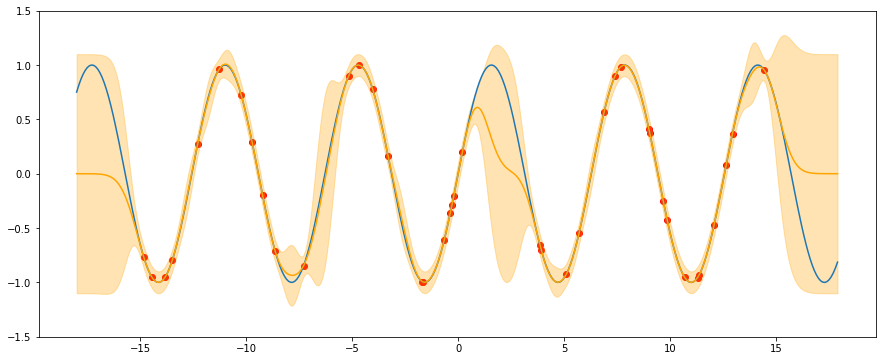

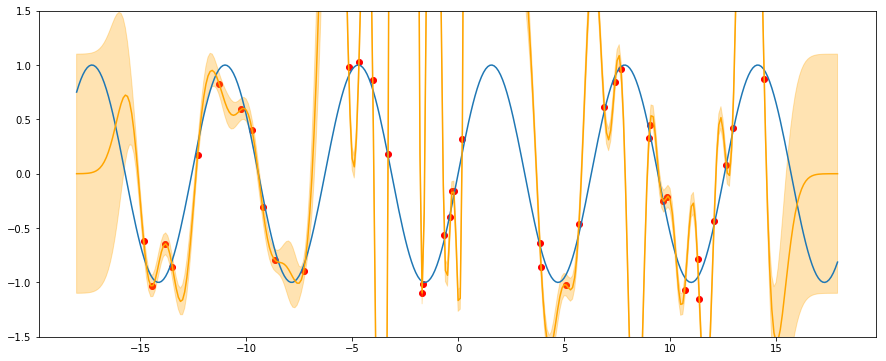

In [7]:
def kernel(x, y):
    dx = x - y
    return np.exp(-1 * np.dot(dx, dx))


class Predictor:
    def __init__(self, target_noise_precision: float = 0.0):
        self.xs = None
        self.k_inv = None
        self.m = None
        self.target_noise_precision = target_noise_precision
    
    def fit(self, xs, ys):
        self.xs = xs
        K = np.array([[kernel(x, y) for y in xs] for x in xs])
        self.k_inv = np.linalg.inv(K)
        self.m = self.k_inv @ ys
    
    def predict(self, xs):
        kx = np.array([[kernel(x, y) for y in self.xs] for x in xs])
        return kx @ self.m
    
    def predict_var(self, xs):
        kxx = np.array([kernel(x, x) for x in xs])
        kx = np.array([[kernel(x, y) for y in self.xs] for x in xs])
        return kxx + self.target_noise_precision - np.array([np.dot(x1, x2) for x1, x2 in zip (kx @ self.k_inv, kx)])
    

def gp_learning(xs, ys):
    predictor = Predictor(target_noise_precision=0.1)
    predictor.fit(xs, ys)
    test_ys_pred = predictor.predict(test_xs)
    test_ys_var = predictor.predict_var(test_xs)

    plt.figure(figsize=(15,6))
    plt.scatter(xs, ys, color='red')
    plt.plot(test_xs, test_ys)
    plt.plot(test_xs, test_ys_pred, color='orange')
    plt.fill_between(test_xs,
                     test_ys_pred + test_ys_var,
                     test_ys_pred - test_ys_var,
                     color='orange', alpha=0.3)
    plt.ylim(-1.5, 1.5)
    plt.show()
    

gp_learning(train_xs, train_ys)
gp_learning(train_xs, train_ys_noisy)

<br>

# Connection with ANN
---

ANN behaves like Gaussian Processes when the width of their layer goes to infinity:

* https://papers.nips.cc/paper/8076-neural-tangent-kernel-convergence-and-generalization-in-neural-networks.pdf
* https://papers.nips.cc/paper/9025-on-exact-computation-with-an-infinitely-wide-neural-net.pdf

**TODO**

<br>

### ANN with variance

We will build a model that allows to predict the mode of $x$ as well as the $\sigma^2(x)$, the imprecision around the guess for input $x$:

&emsp; $p(t|x) = \mathcal{N}(t|y(x),\sigma^2(x))$
&emsp; instead of
&emsp; $p(t|x) = \mathcal{N}(t|y(x),\sigma^2)$

This means that we cannot use the minimum square error, which corresponds to a variance $\sigma^2$ of the noise that is constant. To get the formula, we need to maximize the negative log likelihood:

&emsp; $\displaystyle E = - \log p(D) = \frac{1}{2} \sum_n \Bigg ( \log \big (2 \pi \sigma^2(x) \big) + \frac{1}{\sigma^2(x)} (t_n - y(x_n))^2 \Bigg )$

100%|██████████| 5000/5000 [03:18<00:00, 25.13it/s]


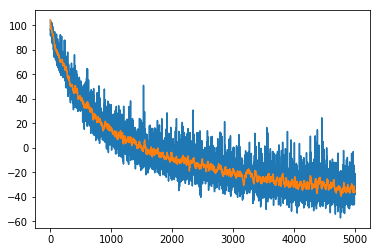

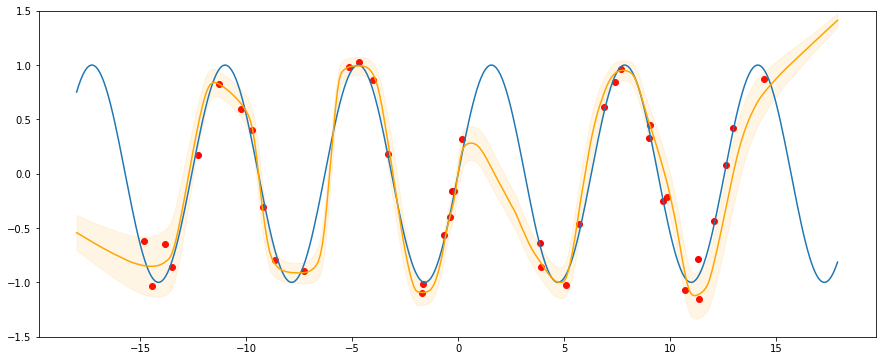

In [47]:
class ANN(nn.Module):
    def __init__(self, hidden_levels: int, hidden_size: int):
        super().__init__()
        levels = []
        for _ in range(hidden_levels):
            levels.append(nn.Linear(hidden_size, hidden_size))
            levels.append(nn.BatchNorm1d(hidden_size))
            levels.append(nn.ReLU())
            levels.append(nn.Dropout(0.2))
        self.fc = nn.Sequential(
            nn.Linear(1, hidden_size),
            nn.ReLU(),
            *levels,
            nn.Linear(hidden_size, 2))
    
    def forward(self, xs):
        return self.fc(xs)

    def fit(self, train_xs, train_ys, epoch_nb: int, lr: float, weight_decay: float=0.):
        self.train()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        ds = data.TensorDataset(torch.FloatTensor(train_xs).unsqueeze(-1),
                                torch.FloatTensor(train_ys).unsqueeze(-1))
        loader = data.DataLoader(ds, batch_size=100, shuffle=True)

        losses = []
        for _ in trange(epoch_nb):
            episode_loss = 0.
            for x, y in loader:
                y_pred = self(x)
                loss = self.criterion(y_pred, y)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 0.1)
                optimizer.step()
                episode_loss += loss.item()
            losses.append(episode_loss)
        return losses

    def predict(self, test_xs):
        self.eval()
        out = self(torch.FloatTensor(test_xs).unsqueeze(-1)).detach().numpy()
        return out[:,0]
    
    def predict_var(self, test_xs):
        self.eval()
        out = self(torch.FloatTensor(test_xs).unsqueeze(-1)).detach().numpy()
        return np.sqrt(np.exp(out[:,1]))
    
    def criterion(self, y_pred, y):
        means = y_pred[:,0]
        variances = torch.exp(y_pred[:,1])
        contributions = torch.log(2 * math.pi * variances) + (means - y.squeeze(-1))**2 / variances
        return torch.sum(contributions)

    
def rolling_mean(xs, window: int):
    rolling = np.cumsum(xs)
    for i in reversed(range(window, len(xs))):
        rolling[i] = (rolling[i] - rolling[i-window]) / window
    for i in range(window):
        rolling[i] /= (i+1)
    return rolling


model = ANN(hidden_levels=5, hidden_size=256)
losses = model.fit(train_xs, train_ys_noisy, epoch_nb=5000, lr=1e-4, weight_decay=0.)
plt.plot(losses)
plt.plot(rolling_mean(losses, window=20))
plt.show()

ys_pred = model.predict(test_xs)
ys_var = model.predict_var(test_xs)

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys_noisy, color='red')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, ys_pred, color='orange')
plt.fill_between(test_xs, ys_pred - ys_var, ys_pred + ys_var, color='orange', alpha=0.1)
plt.ylim(-1.5, 1.5)
plt.show()

<br>

# Support Vector Machines
---

Problems with the Gaussian Process approach:

* storing all the inputs and computing the similarity of new inputs $x$ to all the already stored inputs $x_n$ takes $O(N)$ times
* reversing a matrix of size $N \times N$ takes $O(N^3)$ which means it cannot handle too large inputs space
* outside of the range of inputs, the approach does not provide good approximation (but this is classic)
* over-fitting because each and every point must be matched (sensitivity to noise)


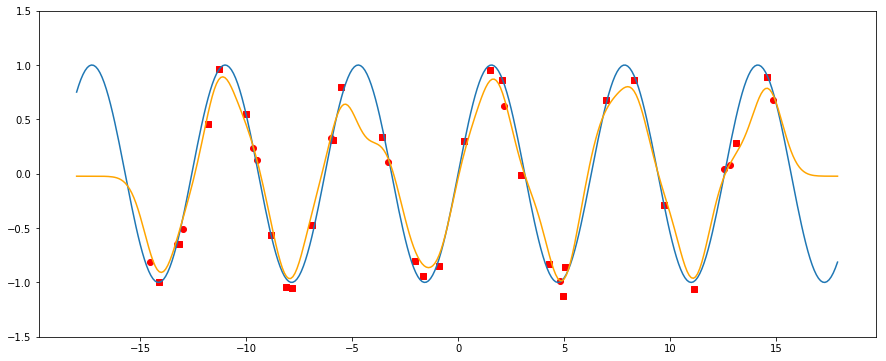

In [160]:
from sklearn.svm import SVR

model = SVR(gamma='auto')
model.fit(np.expand_dims(train_xs, -1), train_ys_noisy)
test_ys_pred = model.predict(np.expand_dims(test_xs, -1))

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys_noisy, color='red')
plt.scatter(train_xs[model.support_], train_ys_noisy[model.support_], marker='s', color='red')
plt.plot(test_xs, test_ys)
plt.plot(test_xs, test_ys_pred, color='orange')
plt.ylim(-1.5, 1.5)
plt.show()

<br>

# Relevance Vector Machines (Sparse Kernel Machine)
---

Problems with SVM (Support Vector Machines):

* we have classification without probabilities, which does not allow to leverage utility theory
* SVM only works for two classes, and generalisations to multiple classes are still not satisfactory
* we sometimes end up with a lot of support vectors (need to tune the sensitivity)

The RVM solve these problems.

<br>

### Uniform priors on weights

We start with the simple formulation we already had for the regression problem with "weight decay".

&emsp; $p(t|x) = N(t|y(x),\beta^{-1})$, where $\beta$ is the precision (inverse of variance) of the noise

&emsp; $p(w) = N(w|0,\alpha^{-1} I_n)$, where $\alpha$ is the precision of the weights

&emsp; $y(x) = w^T \phi(x)$ is our (linear) model

&emsp; $p(D|w) = \prod_n p(t_n|w^T \phi(x_n))$ is the likelihood function (maximizing it would give $w_{ML}$)

&emsp; $p(w|D) \propto p(w) \prod_n p(t_n|w^T \phi(x_n))$ is the a posteriori distribution of weights

Maximizing this last probability would give $w_{MAP}$. We do this by minimizing the negative log of $p(w|D)$, which gives:

&emsp; $J(w) = - \log p(w) - \sum_n \log p(t_n|w^T \phi(x_n)) = \frac{\alpha}{2} w^T w + \frac{\beta}{2} (t_n - w^T \phi(x_n))^2 + const$

Which gives the formula for the regression with weight decay: we see we have a uniform prior on the values of the weights. RVM will slightly change the problem and introduce non-uniform weights.

<br>

### Non uniform prior on weights

RVM introduce two modification from the previous definition. First, each weights will have a different precision (but are kept independent) and we will try to learn these precisions (they are parameters):

&emsp; $p(w) = \prod_n \mathcal{N}(w_n|0,\alpha_n^{-1}) = \mathcal{N}(w|0,A^{-1})$, with precision matrix $A = diag(\alpha_i)$

Second, the function $y(x)$ is modified to use a kernel (measure of similarity with the inputs):

&emsp; $y(x) = \sum_n w_n^T k(x, x_n) + b$

And so we can model the probability of the target, given the inputs, as:

&emsp; $p(t|w) = \prod_n \mathcal{N}(t_n|\sum_i k(x_n, x_i) w_i, \beta^{-1})$, where we see appear the $n^{th}$ row of the kernel matrix $K$

Which we can group again (as for the w) as a multi variate gaussian:

&emsp; $p(t|w) = \mathcal{N}(t|Kw, \beta^{-1}I_n)$

Because $p(t|w)$ is a gaussian, centered on a linear combination of the random variable $w$ which is also gaussian, the resulting distribution $p(w|t)$ is also gaussian, and thanks to **formula 2** we can deduce:

&emsp; $p(w|t,\alpha,\beta) = N(w|m,\Sigma)$, with:

* $\Sigma^{-1} = A + \beta K^T K$
* $m = \beta \Sigma K^T t$

We can also use **formula 2** to compute the marginal probability distribution of p(t) (we integrate with respect to $w$):

&emsp; $p(t) = p(t|\alpha,\beta) = \mathcal{N}(0,\beta^{-1}I_n + K A^{-1} K^T)$

These two formulas will given us the learning algorithm that follows.

<br>

### Learning algorithm

The mode of the gaussian (which is its mean) $p(w|t,\alpha,\beta)$ provides us with $w_{MAP}$ for a given set of parameters $\alpha$ and $\beta$. The problem is therefore to estimate the values of $\alpha$ and $\beta$.

We do that iteratively, by first using our formula for $p(t)$ and maximizing it with respect to $\alpha$ and $\beta$, by setting the gradient to zero. This gives us:

* $\alpha_i^{new} = \frac{\gamma_i}{m_i^2}$
* $(\beta^{new})^{-1} = \frac{||t-Km||^2}{N - \sum_i \gamma_i}$
* $\gamma_i = 1 - \alpha_i \Sigma_{ii}$

We see that this formula depends on $m = w_{MAP}$, and so we have to re-inject this new values into $p(w|t)$ to get the new value of $m$.

* $\Sigma^{-1} = A + \beta K^T K$
* $m = \beta \Sigma K^T t$

We do this until we satisfy a suitable convergence check (or after a given number of iterations). At this point, we have a list of parameters $m_i$ and $\alpha_i$ (for mean and variance) for each of our sample points.

<br>

### Prediction

A lot of the values $\alpha_i$ will have diverged toward infinity. These data points with high precisions number will not participate in the predictions of values around them (precision is the inverse of variance): these data points and their high precisions only participate in overfitting the data, making sure that each point of the data set is matched.

So we remove these data points, and keep only the $x_n$ points with low precisions. After that, we get:

* $X$ is the list of data points that corresponds to "support vectors"
* $m$ is the list of means that matches the data points $X$ we selected
* $\Sigma$ is the covariance of the data points $X$ we selected

These are computed as we saw above with the formulas:

* $(K)_{nm} = k(x_n, x_m)$
* $\Sigma^{-1} = A + \beta K^T K$
* $m = \beta \Sigma K^T t$

Now, to handle new inputs $x$, we just compute $k(x)$ the vector that corresponds to the affinity to $x$ to the points $X$ is, and use this compound the modes (means) of the gaussians, a kind of weighted average, similar to what we did with Gaussian Processes:

&emsp; $y(x) = k(x)^T m$

&emsp; $k(x)^T = (k(x, x_1),..., k(x, x_n))$

We can also compute the variance around the predictions, same as we did for the Gaussian Processes, by using **formula 1**:

&emsp; $\sigma^2(x) = k(x,x) + \beta^{-1} - k(x)^T \Sigma k(x)$

**TODO - wrong: see the book**

<br>

### Example

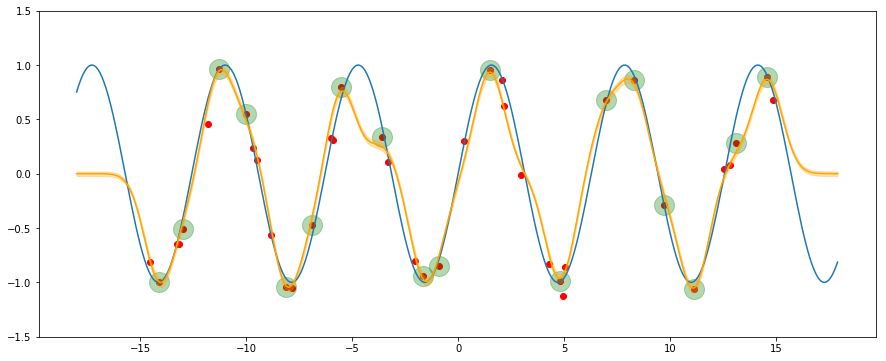

In [251]:
def kernel(x, y):
    dx = x - y
    return np.exp(-1 * np.dot(dx, dx))


class RVM:
    def __init__(self):
        self.alpha = None
        self.beta = None
        self.xs = None
    
    def fit(self, xs, ys, epoch_nb: int):
        n_weights = len(xs)        
        K = np.array([[kernel(x, y) for y in xs] for x in xs])
        alpha = np.ones(n_weights)
        beta = 1.
        
        for epoch in range(epoch_nb):
            precision = np.diag(alpha) + beta * K.T @ K
            cov = np.linalg.inv(precision)
            mean = beta * cov @ K.T @ ys
            gamma = 1 - alpha * np.diag(cov)
            alpha = gamma / np.square(mean)
            np.clip(alpha, 0, 1e10, out=alpha)
            beta = (n_weights - np.sum(gamma)) / np.linalg.norm(ys - K @ mean)
        
        mask = alpha < 1e4
        self.alpha = alpha[mask]
        self.xs = xs[mask]
        self.ys = ys[mask]
        self.beta = beta
        
        K = np.array([[kernel(x, y) for y in self.xs] for x in self.xs])
        precision = np.diag(self.alpha) + self.beta * K.T @ K
        self.covariance = np.linalg.inv(precision)
        self.mean = self.beta * self.covariance @ K.T @ self.ys
        
    def predict(self, xs):
        out = []
        for x in xs:
            k = np.array([kernel(x, x_i) for x_i in self.xs])
            y = np.dot(self.mean, k)
            out.append(y)
        return np.array(out)
    
    def predict_var(self, xs):
        out = []
        for x in xs:
            k = np.array([kernel(x, x_i) for x_i in self.xs])
            # var = kernel(x, x) + 1 / self.beta - k.T @ self.covariance @ k
            var = 1 / self.beta + k.T @ self.covariance @ k
            out.append(var)
        return np.array(out)
            
    
model = RVM()
model.fit(train_xs, train_ys_noisy, epoch_nb=100)
test_ys_pred = model.predict(test_xs)
test_ys_var = model.predict_var(test_xs)

plt.figure(figsize=(15,6))
plt.scatter(train_xs, train_ys_noisy, color='red')
plt.scatter(model.xs, model.ys, s=400, color="g", alpha=0.3)
plt.plot(test_xs, test_ys)
plt.plot(test_xs, test_ys_pred, color='orange')
plt.fill_between(test_xs,
                 test_ys_pred + test_ys_var,
                 test_ys_pred - test_ys_var,
                 color='orange', alpha=0.3)
plt.ylim(-1.5, 1.5)
plt.show()